In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from datetime import datetime
import numpy as np


In [2]:
from PIL import Image
import numpy as np

img = Image.open("A.jpg")  # 존재하는 이미지 파일
arr = np.array(img)
print("Image shape:", arr.shape)
print("Array dtype:", arr.dtype)


Image shape: (410, 346, 3)
Array dtype: uint8


In [3]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA version seen by PyTorch:", torch.version.cuda)
print("CUDA is available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("⚠️ CUDA is NOT available")


PyTorch Version: 2.2.2
CUDA version seen by PyTorch: 12.1
CUDA is available: True
GPU Name: NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [4]:
# 설정
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [5]:
# 데이터 전처리
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# 데이터 경로
train_dir = './cats_and_dogs_filtered/cats_and_dogs_filtered/train'
test_dir = './cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
from torchvision import models
import torch.nn as nn

# 사전학습된 ResNet-18 불러오기
from torchvision import models

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

# 출력층 수정 (기존: 1000개 클래스 → 2개 클래스)
model.fc = nn.Linear(model.fc.in_features, 2)  # 'cat'과 'dog'
model = model.to(DEVICE)
model.eval()


In [6]:
# 모델 설정
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, NUM_CLASSES)
model = model.to(DEVICE)

# 손실함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# 저장 설정
save_path = 'cats_and_dogs_filtered_vgg16_pytorch.pth'
best_loss = float('inf')
patience = 5
wait = 0

# 시각화를 위한 기록 리스트
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

c:\Users\main\miniconda3\envs\torchpip\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\main\miniconda3\envs\torchpip\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# 학습 루프
for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct = 0.0, 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{EPOCHS}'):
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct.double() / len(train_loader.dataset)

    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_loss /= len(test_loader.dataset)
    val_acc = val_correct.double() / len(test_loader.dataset)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    # 기록 저장
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())

    # EarlyStopping & Checkpoint
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), save_path)
        wait = 0
        print("✔️ Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("🛑 Early stopping.")
            break

Epoch 1/30: 100%|██████████| 63/63 [00:22<00:00,  2.82it/s]


Epoch 1: Train Loss=0.3094, Acc=0.8560 | Val Loss=0.0469, Acc=0.9820
✔️ Best model saved.


Epoch 2/30: 100%|██████████| 63/63 [00:22<00:00,  2.86it/s]


Epoch 2: Train Loss=0.1530, Acc=0.9355 | Val Loss=0.0290, Acc=0.9890
✔️ Best model saved.


Epoch 3/30: 100%|██████████| 63/63 [00:23<00:00,  2.73it/s]


Epoch 3: Train Loss=0.1383, Acc=0.9435 | Val Loss=0.0300, Acc=0.9880


Epoch 4/30: 100%|██████████| 63/63 [00:23<00:00,  2.74it/s]


Epoch 4: Train Loss=0.1041, Acc=0.9595 | Val Loss=0.0301, Acc=0.9890


Epoch 5/30: 100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


Epoch 5: Train Loss=0.1027, Acc=0.9565 | Val Loss=0.0434, Acc=0.9860


Epoch 6/30: 100%|██████████| 63/63 [00:22<00:00,  2.81it/s]


Epoch 6: Train Loss=0.1037, Acc=0.9525 | Val Loss=0.0333, Acc=0.9870


Epoch 7/30: 100%|██████████| 63/63 [00:22<00:00,  2.79it/s]


Epoch 7: Train Loss=0.0830, Acc=0.9650 | Val Loss=0.0304, Acc=0.9910
🛑 Early stopping.


In [8]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")


features.0.weight: torch.Size([64, 3, 3, 3])
features.0.bias: torch.Size([64])
features.2.weight: torch.Size([64, 64, 3, 3])
features.2.bias: torch.Size([64])
features.5.weight: torch.Size([128, 64, 3, 3])
features.5.bias: torch.Size([128])
features.7.weight: torch.Size([128, 128, 3, 3])
features.7.bias: torch.Size([128])
features.10.weight: torch.Size([256, 128, 3, 3])
features.10.bias: torch.Size([256])
features.12.weight: torch.Size([256, 256, 3, 3])
features.12.bias: torch.Size([256])
features.14.weight: torch.Size([256, 256, 3, 3])
features.14.bias: torch.Size([256])
features.17.weight: torch.Size([512, 256, 3, 3])
features.17.bias: torch.Size([512])
features.19.weight: torch.Size([512, 512, 3, 3])
features.19.bias: torch.Size([512])
features.21.weight: torch.Size([512, 512, 3, 3])
features.21.bias: torch.Size([512])
features.24.weight: torch.Size([512, 512, 3, 3])
features.24.bias: torch.Size([512])
features.26.weight: torch.Size([512, 512, 3, 3])
features.26.bias: torch.Size([51

📉 최소 / 최대 Loss
Train Loss: min = 0.0830, max = 0.3094
Val   Loss: min = 0.0290, max = 0.0469

📈 최소 / 최대 Accuracy
Train Acc : min = 0.8560, max = 0.9650
Val   Acc : min = 0.9820, max = 0.9910


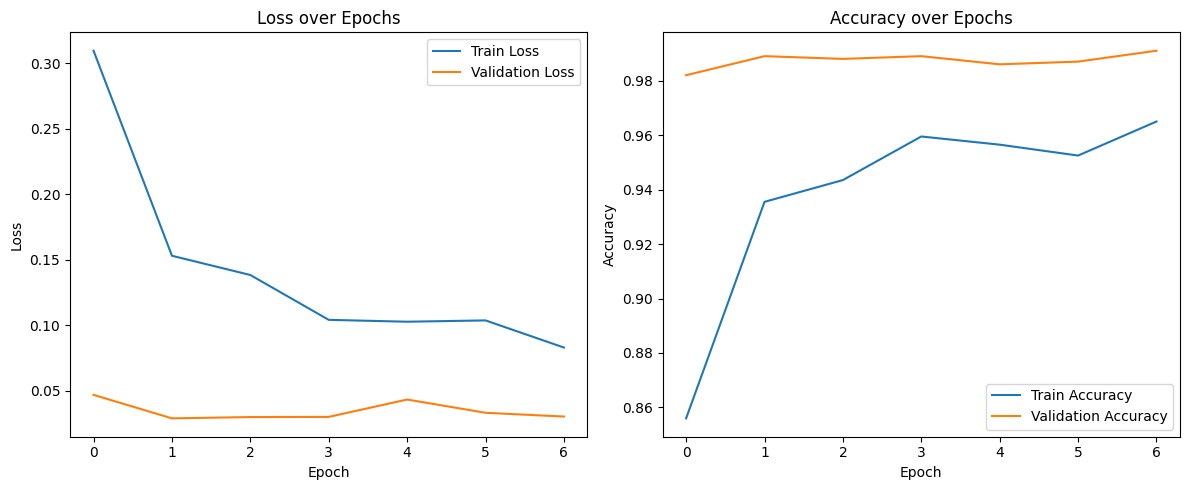

In [33]:
print("📉 최소 / 최대 Loss")
print(f"Train Loss: min = {min(train_losses):.4f}, max = {max(train_losses):.4f}")
print(f"Val   Loss: min = {min(val_losses):.4f}, max = {max(val_losses):.4f}")

print("\n📈 최소 / 최대 Accuracy")
print(f"Train Acc : min = {min(train_accuracies):.4f}, max = {max(train_accuracies):.4f}")
print(f"Val   Acc : min = {min(val_accuracies):.4f}, max = {max(val_accuracies):.4f}")


# 학습 그래프 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
import cv2
import glob
import os

# 사용자 로컬 경로 지정
folder_path = './datasets/cat_dog'  # 이 경로는 실제 이미지 폴더로 바꿔주세요
test_img_name_list = glob.glob(os.path.join(folder_path, '*'))

# 전처리 수행
IMG_WIDTH = 224
IMG_HEIGHT = 224

for i in range(len(test_img_name_list)):
    # 이미지 로드 및 전처리
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img = dst_img / 255.0

    # 전처리된 이미지로 덮어쓰기
    test_img_name_list[i] = dst_img

print(len(test_img_name_list))


12


다음은 이미지에서 추출한 **텍스트 원문 그대로**입니다:

---

```
glob.glob(“test_image_dir/*”)
test_image_dir 경로 안에 있는 모든 파일을 선택하여 변수에 저장

glob.glob() 함수 : 파일의 이름 패턴에 대해 매칭을 수행하여 동일한 패턴만 반환.
* : 임의의 문자열을 의미함.
? : 임의의 한 글자와 일치함.
[characters] : characters 내의 문자와 일치함.
[!characters] : characters 내의 문자를 제외하고 일치함.

예)
*.txt : 현재 위치의 모든 텍스트 파일(*.txt)만 필터링
data/*.jpg : data 폴더 내의 모든 jpg 파일
data/*.jp*g : data 폴더 내의 jpg, jpeg, jpgx 등 jpg와 유사한 확장자를 포함
data/img_[1-3].png : img_1.png, img_2.png, img_3.png 과 같은 파일 필터링
data/img_?.png : img_1.png, img_a.png 등 이름이 1글자인 경우 필터링
file[!0-9].pdf : file 이름에 숫자가 포함되지 않는 pdf 파일 필터링


https://colab.research.google.com/drive/1NW_Fz55MKv7ZIAxqedQksROU9FshQhHac#scrollTo=Ey3s1kcsx_1

2. Deep Learning

for i in range(len(test_img_name_list)):
    
    src_img = cv2.imread(test_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMG_WIDTH, IMG_HEIGHT))
    dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    dst_img = dst_img / 255.0

    test_img_name_list[i] = dst_img

이미지 리스트에서 읽어(imread( ))
크기조절(resize( ))
BGR에서 RGB로 변환(cvtColor( ))
표준화(dst / 255)
저장

https://colab.research.google.com/drive/1NW_Fz55MKv7ZIAxqedQksROU9FshQhHac#scrollTo=Ey3s1kcsx_1

2. Deep Learning

dst_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB);

cv2.cvtColor() 함수를 사용하여 이미지의 색상 공간을 BGR에서 RGB로 변환.
OpenCV는 기본적으로 BGR 색상 공간을 사용함.
일반적으로 시각화는 RGB 색상 공간을 사용.
```

---


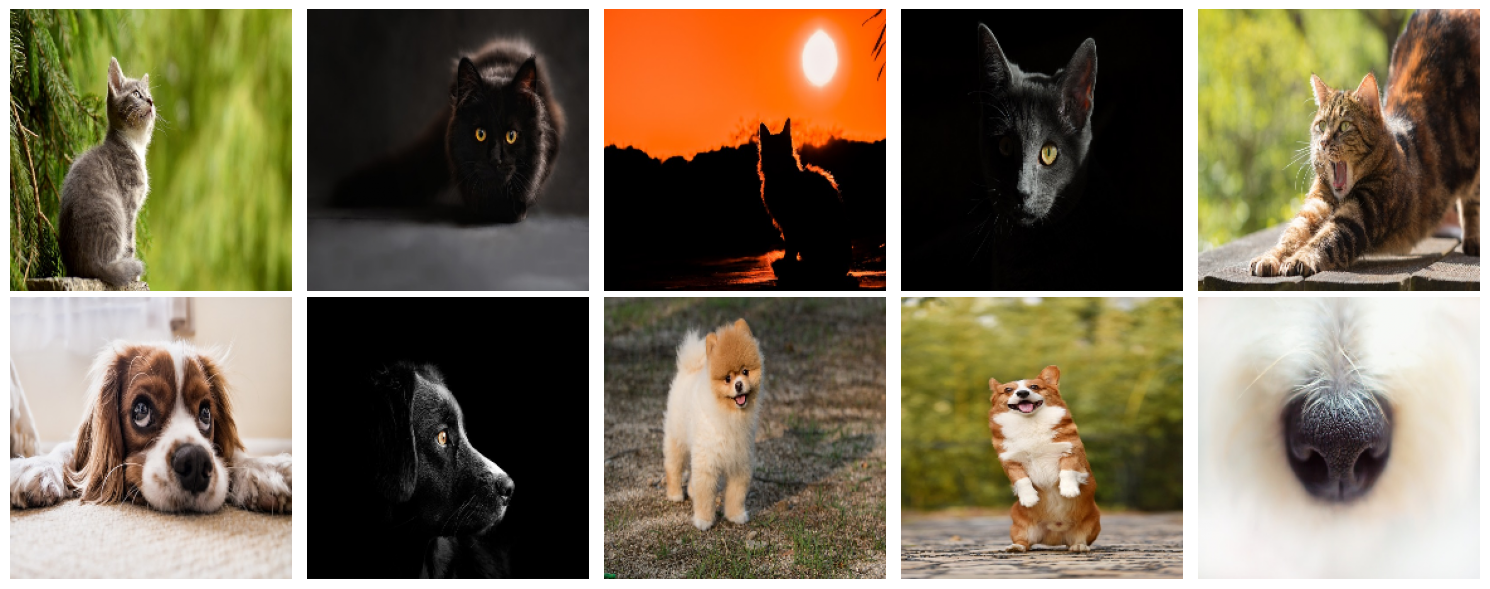

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.axis('off')
    plt.imshow(test_img_name_list[i])
plt.show()

In [15]:
import numpy as np
import torch
from torchvision import transforms

# 클래스 이름 가져오기 (ImageFolder 사용했을 때 기준)
class_names = train_dataset.classes  # ['cat', 'dog']

# 예측 결과 저장용 리스트
pred_class_list = []

# 평가 모드 설정
model.eval()

# 각 이미지에 대해 예측
with torch.no_grad():
    for i in range(len(test_img_name_list)):
        img = test_img_name_list[i]  # shape: (224, 224, 3), dtype: float32 (0~1)

        # [H, W, C] → [C, H, W] 및 Tensor 변환
        img = np.transpose(img, (2, 0, 1))  # (3, 224, 224)
        img = torch.tensor(img, dtype=torch.float32)
        img = img.unsqueeze(0).to(DEVICE)  # 배치 차원 추가 → (1, 3, 224, 224)

        # 예측
        outputs = model(img)
        _, pred = torch.max(outputs, 1)
        pred_class = class_names[pred.item()]

        pred_class_list.append(pred_class)


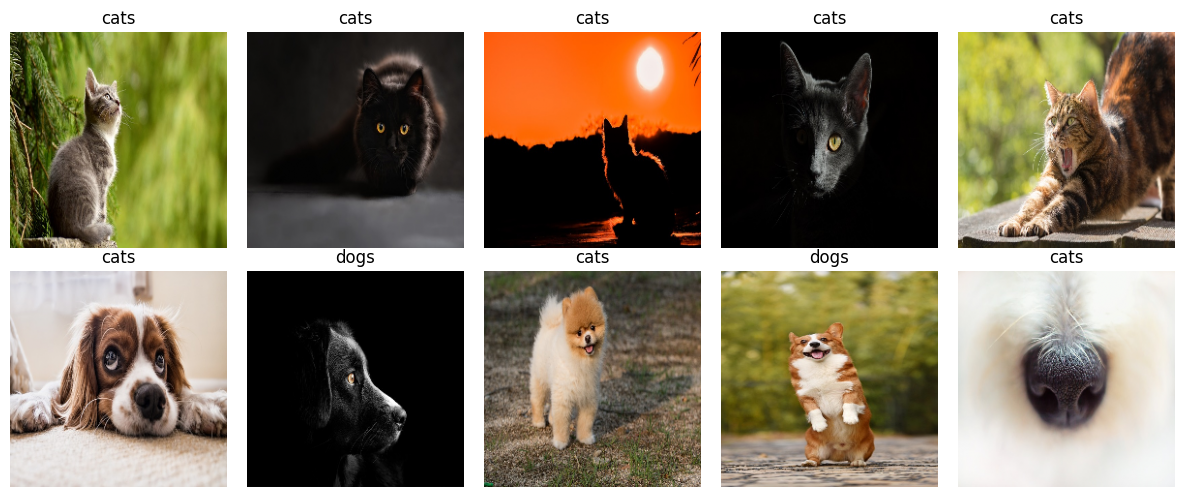

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(test_img_name_list[i])
    plt.title(pred_class_list[i])  # 예측 클래스명 표시
plt.tight_layout()
plt.show()


IndexError: index 1 is out of bounds for dimension 0 with size 1

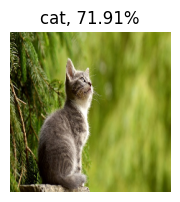

In [ ]:
plt.figure(figsize=(12,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    prediction = str(class_name[np.argmax(pred[i])])
    problility = '{0:0.2f}'.format(100*max(pred[i]))
    title_str = prediction + ', ' + problility + '%'
    plt.axis('off')
    plt.title(title_str)
    plt.imshow(test_img_name_list[i])
plt.show()

In [22]:
import os
import glob
from PIL import Image
import torch
from torchvision import transforms
from timm import create_model

# 클래스 이름 정의
class_names = ['cat', 'dog']

# 디바이스 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 불러오기
from torchvision import models
import torch.nn as nn

model = models.vgg16(pretrained=False)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model.load_state_dict(torch.load('cats_and_dogs_filtered_vgg16_pytorch.pth'))
model = model.to(DEVICE)
model.eval()


# 이미지 전처리 정의
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Xception 권장 입력 크기
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # timm 표준 정규화
])

# 이미지 폴더 지정
image_folder = './datasets/cat_dog'
image_paths = glob.glob(os.path.join(image_folder, '*'))

# 결과 저장 리스트
results = []

with torch.no_grad():
    for image_path in image_paths:
        # 이미지 불러오기
        image = Image.open(image_path).convert("RGB")
        input_tensor = transform(image).unsqueeze(0).to(DEVICE)

        # 예측 수행
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)
        pred_class = class_names[pred.item()]

        # 결과 저장
        results.append((os.path.basename(image_path), pred_class))
        print(f"{os.path.basename(image_path)} → Predicted: {pred_class}")


cat1.jpg → Predicted: cat
cat2.jpg → Predicted: cat
cat3.jpg → Predicted: cat
cat4.jpg → Predicted: cat
cat5.jpg → Predicted: cat
dog1.jpg → Predicted: dog
dog2.jpg → Predicted: dog
dog3.jpg → Predicted: dog
dog4.jpg → Predicted: dog
dog5.jpg → Predicted: cat


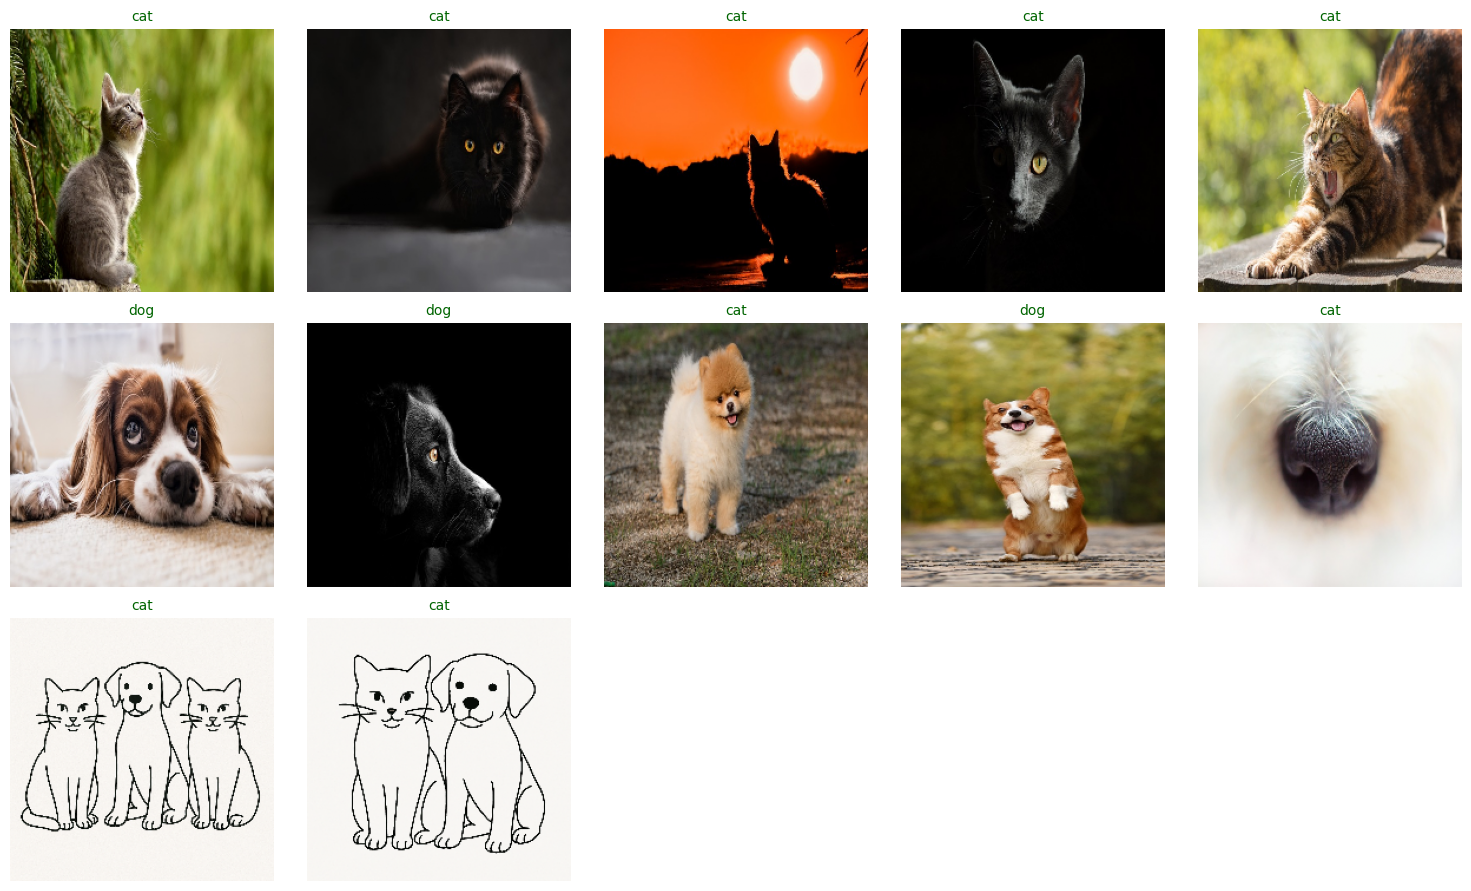

In [31]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import math

# 클래스 이름 예시
class_names = ['cat', 'dog']

# 평가 모드
model.eval()

# 예측 결과 저장용
pred_class_list = []

with torch.no_grad():
    for i in range(len(test_img_name_list)):
        img = test_img_name_list[i]  # shape: (224, 224, 3), dtype: float32

        # [H, W, C] → [C, H, W]로 변환
        img_tensor = torch.tensor(np.transpose(img, (2, 0, 1)), dtype=torch.float32)
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

        # 예측 수행
        outputs = model(img_tensor)
        _, pred = torch.max(outputs, 1)
        pred_label = class_names[pred.item()]
        pred_class_list.append(pred_label)

# 시각화
num_images = len(test_img_name_list)
cols = 5
rows = math.ceil(num_images / cols)

plt.figure(figsize=(cols * 3, rows * 3))
for i in range(num_images):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(test_img_name_list[i])
    plt.title(pred_class_list[i], fontsize=10, color='darkgreen')  # 예측 클래스 이름 표시

plt.tight_layout()
plt.show()
